<a href="https://colab.research.google.com/github/tpmmthomas/Sepsis-diagnosis-from-pairwise-single-cell-RNA-Continued/blob/master/NEW_NEW_capsnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, BatchNormalization
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras import initializers, layers
import os


In [2]:
"""
Some key layers used for constructing a Capsule Network. These layers can used to construct CapsNet on other dataset, 
not just on MNIST.
*NOTE*: some functions can be implemented in multiple ways, I keep all of them. You can try them for yourself just by
uncommenting them and commenting their counterparts.
Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""



class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=tf.shape(x)[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=(self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule),
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
            # Expand the input in axis=1, tile in that axis to num_capsule, and 
      # expands another axis at the end to prepare the multiplication with W.
      #  inputs.shape=[None, input_num_capsule, input_dim_capsule]
      #  inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
      #  inputs_tiled.shape=[None, num_capsule, input_num_capsule, 
      #                            input_dim_capsule, 1]
      inputs_expand = tf.expand_dims(inputs, 1)
      inputs_tiled  = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1])
      inputs_tiled  = tf.expand_dims(inputs_tiled, 4)

      # Compute `W * inputs` by scanning inputs_tiled on dimension 0 (map_fn).
      # - Use matmul (without transposing any element). Note the order!
      # Thus:
      #  x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
      #  W.shape=[num_capsule, input_num_capsule, dim_capsule,input_dim_capsule]
      # Regard the first two dimensions as `batch` dimension,
      # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1]-> 
      #              [dim_capsule, 1].
      #  inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule, 1]
      
      inputs_hat = tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled)     

      # Begin: Routing algorithm ----------------------------------------------#
      # The prior for coupling coefficient, initialized as zeros.
      #  b.shape = [None, self.num_capsule, self.input_num_capsule, 1, 1].
      b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.num_capsule, 
                          self.input_num_capsule, 1, 1])

      assert self.routings > 0, 'The routings should be > 0.'
      for i in range(self.routings):
        # Apply softmax to the axis with `num_capsule`
        #  c.shape=[batch_size, num_capsule, input_num_capsule, 1, 1]
        c = layers.Softmax(axis=1)(b)

        # Compute the weighted sum of all the predicted output vectors.
        #  c.shape =  [batch_size, num_capsule, input_num_capsule, 1, 1]
        #  inputs_hat.shape=[None, num_capsule, input_num_capsule,dim_capsule,1]
        # The function `multiply` will broadcast axis=3 in c to dim_capsule.
        #  outputs.shape=[None, num_capsule, input_num_capsule, dim_capsule, 1]
        # Then sum along the input_num_capsule
        #  outputs.shape=[None, num_capsule, 1, dim_capsule, 1]
        # Then apply squash along the dim_capsule
        outputs = tf.multiply(c, inputs_hat)
        outputs = tf.reduce_sum(outputs, axis=2, keepdims=True)
        outputs = squash(outputs, axis=-2)  # [None, 10, 1, 16, 1]

        if i < self.routings - 1:
          # Update the prior b.
          #  outputs.shape =  [None, num_capsule, 1, dim_capsule, 1]
          #  inputs_hat.shape=[None,num_capsule,input_num_capsule,dim_capsule,1]
          # Multiply the outputs with the weighted_inputs (inputs_hat) and add  
          # it to the prior b.  
          outputs_tiled = tf.tile(outputs, [1, 1, self.input_num_capsule, 1, 1])
          agreement = tf.matmul(inputs_hat, outputs_tiled, transpose_a=True)
          b = tf.add(b, agreement)

      # End: Routing algorithm ------------------------------------------------#
      # Squeeze the outputs to remove useless axis:
      #  From  --> outputs.shape=[None, num_capsule, 1, dim_capsule, 1]
      #  To    --> outputs.shape=[None, num_capsule,    dim_capsule]
      outputs = tf.squeeze(outputs, [2, 4])
      return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv1D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)





In [3]:
#Transformer Structure
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [4]:
xtrain = r"NEWdata/NEW_training_sample.csv.gz"
ytrain = r"NEWdata/NEW_training_label.csv.gz"
xtest = r"NEWdata/NEW_testing_sample.csv.gz"
ytest = r"NEWdata/NEW_testing_label.csv.gz"

i=0
samplesdf = pd.read_csv(xtrain,compression ="gzip",delimiter=',')
x_train = samplesdf.to_numpy()

samplesdf = pd.read_csv(ytrain,compression ="gzip",delimiter=',')
y_train = samplesdf.to_numpy()
'''
y_train = np.zeros((x_train.shape[0],2))
for yt in y_trai:
    if yt == 0:
        y_train[i] = [1,0]
    else:
        y_train[i] = [0,1]
    i = i + 1
'''
samplesdf = pd.read_csv(xtest,compression ="gzip",delimiter=',')
x_test = samplesdf.to_numpy()

samplesdf = pd.read_csv(ytest,compression ="gzip",delimiter=',')
y_test = samplesdf.to_numpy()
'''
y_test = np.zeros((x_test.shape[0],2))
i = 0
for yt in y_tes:
    if yt == 0:
        y_test[i] = [1,0]
    else:
        y_test[i] = [0,1]
    i = i + 1
'''

print("done")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



done
(38483, 3030)
(38483, 1)
(4265, 3030)
(4265, 1)


In [5]:
def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    inputs = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv1D(filters=256, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv1')(inputs)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=64, n_channels=3, kernel_size=5, strides=2, padding='valid')
    
    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=64, routings=routings,
                             name='digitcaps')(primarycaps)
    

    
    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    #out_caps = Length(name='capsnet')(digitcaps) 
    """
    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
#    dec_3 = decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid', input_dim=10*n_class))
#    dec_1 = decoder.add(layers.Dense(16, activation='relu', input_dim=10*n_class))
#    dec_2 = decoder.add(layers.Dense(16, activation='relu'))
#    decoder.add(layers.Dropout(0.40))
#    dec_3 = decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    dec_4 = decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))
"""

#--------------------------------------------------------------------------------------------------------

    transformer_block = TransformerBlock(64, 2, 512)
    x = transformer_block(digitcaps)

    #x = layers.GlobalMaxPooling1D()(x)
  

    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(150, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    #model = keras.Model(inputs=inputs, outputs=outputs)
    return model
'''
#----------------------------------------------------------------------------------------------------below is skipped
    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [digitcaps, decoder(masked)]) #masked_by_y
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 10))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model
'''

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))





def test(model, X_test, y_test, args):
    y_pred, x_recon = model.predict(X_test, batch_size=20)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])
    return y_pred

def manipulate_latent(model, X_train, y_train, X_test, y_test, args):
    print('-'*30 + 'Begin: manipulate' + '-'*30)
    index = np.argmax(y_test, 1) == args.digit
    number = np.random.randint(low=0, high=sum(index) - 1)
    x, y = X_test[index][number], y_test[index][number]
    x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
    noise = np.zeros([1, 10, 16])
    x_recons = []
    for dim in range(16):
        for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
            tmp = np.copy(noise)
            tmp[:,:,dim] = r
            x_recon = model.predict([x, y, tmp])
            x_recons.append(x_recon)

    x_recons = np.concatenate(x_recons)

In [10]:
x_train=tf.reshape(x_train,(38483,3030,1))
x_test=tf.reshape(x_test,(4265,3030,1))
print(x_train.shape)
print(x_test.shape)

        
# define model
with tf.device("cpu:0"):
    model= CapsNet(input_shape=x_train[1,:,:].shape,n_class=2,routings=3)
    model.summary()

(38483, 3030, 1)
(4265, 3030, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3030, 1)]         0         
_________________________________________________________________
conv1 (Conv1D)               (None, 3026, 256)         1536      
_________________________________________________________________
primarycap_conv2d (Conv1D)   (None, 1511, 192)         245952    
_________________________________________________________________
primarycap_reshape (Reshape) (None, 4533, 64)          0         
_________________________________________________________________
primarycap_squash (Lambda)   (None, 4533, 64)          0         
_________________________________________________________________
digitcaps (CapsuleLayer)     (None, 2, 64)             37134336  
_________________________________________________________________
transformer_block (Transform

In [12]:


    # train or test
    # compile the model
#model.compile(optimizer=optimizers.Adam(lr=1, amsgrad=True),loss=[margin_loss, 'binary_crossentropy'],loss_weights=[1, 2], metrics=["accuracy"])

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])


    # Training without data augmentation:
hist = model.fit(x_train, y_train, batch_size=128, epochs=10,validation_data=(x_test, y_test),
               shuffle=True)


AttributeError: module 'tensorflow' has no attribute 'enable_resource_variables'

In [14]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

AUPRC = 0.94
f1_score = 0.86


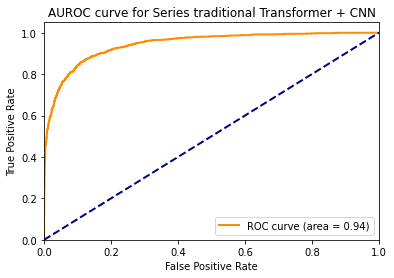

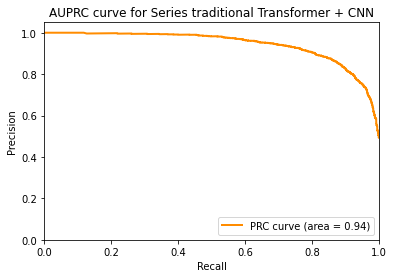

In [14]:
testresult=model.predict(x_test)

i = 0
correct = 0
for x in testresult:
    if x >=0.5 and y_test[i] == 1:
        correct = correct + 1
    elif x < 0.5 and y_test[i] == 0:
        correct = correct + 1
    i = i + 1
testacc = correct/i
testacc

fpr, tpr, _ = roc_curve(y_test,testresult)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC curve for Series traditional Transformer + CNN')
plt.legend(loc="lower right")
plt.figure()
precision, recall, _ = precision_recall_curve(y_test,testresult)
prc_auc = auc(recall,precision)
plt.plot(recall,precision, color='darkorange',
         lw=lw, label='PRC curve (area = %0.2f)' % prc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC curve for Series traditional Transformer + CNN')
plt.legend(loc="lower right")
print("AUPRC = %.02f"% prc_auc)
ss = np.zeros((len(testresult)))
i = 0
for x in testresult:
    if x >= 0.5:
        ss[i] = 1
    else:
        ss[i] = 0
    i = i + 1
f1s = f1_score(y_test,ss)
print("f1_score = %.02f"% f1s)